In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.stateless import functional_call
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##############################
# Define a simple CNN model
##############################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # Output: (32, 26, 26)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)          # Output: (32, 13, 13)
        self.fc = nn.Linear(32 * 13 * 13, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

##############################
# Hyperparameters
##############################
num_classes = 10
ipc = 10                         # images per class in synthetic set
num_syn = num_classes * ipc      # total synthetic images
inner_steps = 10                 # number of inner-loop (synthetic training) steps
meta_iterations = 1000           # meta-iterations for distillation
lr_model = 0.01                  # inner-loop learning rate
lr_syn = 0.1                     # synthetic data learning rate

# Loss function
criterion = nn.CrossEntropyLoss()

##############################
# Load MNIST dataset (real data)
##############################
transform = transforms.Compose([
    transforms.ToTensor(),  # converts images to [0,1] tensors
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
real_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)

##############################
# Initialize synthetic dataset
##############################
# Synthetic images: parameter tensor of shape (num_syn, 1, 28, 28)
syn_images = torch.randn(num_syn, 1, 28, 28, device=device, requires_grad=True)
# Synthetic labels: for each class repeated ipc times (0,...,9)
syn_labels = torch.tensor([i for i in range(num_classes) for _ in range(ipc)], device=device)

# Optimizer for synthetic images
syn_optimizer = optim.SGD([syn_images], lr=lr_syn)

##############################
# Helper: Inner-loop update (using functional updates)
##############################
def inner_loop(model, init_params, syn_images, syn_labels, inner_steps, lr_model):
    params = init_params
    for t in range(inner_steps):
        # Forward pass on synthetic data using the current parameters
        outputs = functional_call(model, params, syn_images)
        loss = criterion(outputs, syn_labels)
        # Compute gradients w.r.t. model parameters (create_graph=True to enable second-order gradients)
        grads = torch.autograd.grad(loss, params.values(), create_graph=True)
        # Update each parameter functionally
        params = {name: param - lr_model * grad 
                  for (name, param), grad in zip(params.items(), grads)}
    return params

##############################
# Meta-training loop (distillation)
##############################
print("Starting meta-training (dataset distillation)...")
for meta_iter in range(meta_iterations):
    # Initialize a new model and get its parameters as a dict (these are the "inner-loop" model parameters)
    model = SimpleCNN().to(device)
    model.train()
    init_params = {name: param.clone() for name, param in model.named_parameters()}

    # Perform inner-loop updates using the current synthetic dataset
    final_params = inner_loop(model, init_params, syn_images, syn_labels, inner_steps, lr_model)
    
    # Sample a batch from the real dataset to compute meta-loss
    try:
        real_batch = next(real_iter)
    except Exception:
        real_iter = iter(real_loader)
        real_batch = next(real_iter)
    real_imgs, real_lbls = real_batch
    real_imgs, real_lbls = real_imgs.to(device), real_lbls.to(device)
    
    # Evaluate the model (with final_params) on real data and compute meta-loss
    meta_outputs = functional_call(model, final_params, real_imgs)
    meta_loss = criterion(meta_outputs, real_lbls)
    
    # Backpropagate meta-loss through the inner loop to update synthetic images
    syn_optimizer.zero_grad()
    meta_loss.backward()
    syn_optimizer.step()

    # Clamp synthetic images to [0,1] for valid pixel values
    with torch.no_grad():
        syn_images.clamp_(0, 1)

    if meta_iter % 100 == 0:
        print(f"Meta iteration {meta_iter}: Meta loss = {meta_loss.item():.4f}")

print("Meta-training finished.")

##############################
# Evaluation: Train a new model on the distilled synthetic dataset
##############################
print("Training evaluation model on distilled synthetic dataset...")

# Create a TensorDataset and DataLoader from the distilled synthetic images
syn_dataset = TensorDataset(syn_images.detach().cpu(), syn_labels.cpu())
syn_loader = DataLoader(syn_dataset, batch_size=64, shuffle=True)

# Initialize a new model for evaluation
eval_model = SimpleCNN().to(device)
eval_model.train()
eval_optimizer = optim.SGD(eval_model.parameters(), lr=lr_model)

# Train on synthetic data for a few epochs
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for imgs, labels in syn_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        eval_optimizer.zero_grad()
        outputs = eval_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        eval_optimizer.step()
        epoch_loss += loss.item() * imgs.size(0)
    epoch_loss /= len(syn_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Synthetic training loss: {epoch_loss:.4f}")

##############################
# Test the evaluation model on the MNIST test set
##############################
print("Evaluating on MNIST test set...")
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

eval_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = eval_model(imgs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_acc = 100.0 * correct / total
print(f"Test accuracy of model trained on distilled data: {test_acc:.2f}%")


Starting meta-training (dataset distillation)...


/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_91350/1979067433.py:71: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  outputs = functional_call(model, params, syn_images)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_91350/1979067433.py:103: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  meta_outputs = functional_call(model, final_params, real_imgs)


Meta iteration 0: Meta loss = 2.2822


KeyboardInterrupt: 

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Use torch.func.functional_call if available (PyTorch 2.0+), else fallback to torch.nn.utils.stateless.functional_call
from torch.func import functional_call


# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#############################################
# Define a simple CNN for MNIST
#############################################
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)


#############################################
# Main training and evaluation routine
#############################################
def main():
    # Hyperparameters
    num_classes = 10
    ipc = 10                         # synthetic images per class
    num_syn = num_classes * ipc      # total number of synthetic images
    inner_steps = 150                # number of inner-loop updates
    meta_iterations = 700            # number of meta-training iterations
    lr_model = 0.01                  # inner-loop (model) learning rate
    lr_syn = 0.1                     # learning rate for updating synthetic images

    #############################################
    # Load MNIST training and test data
    #############################################
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    real_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)

    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=256, shuffle=False)

    #############################################
    # Initialize synthetic dataset as learnable parameters
    #############################################
    syn_images = torch.randn(num_syn, 1, 28, 28, device=device, requires_grad=True)
    # Create synthetic labels: each class repeated ipc times (0,1,...,9)
    syn_labels = torch.tensor([i for i in range(num_classes) for _ in range(ipc)], device=device)

    # Optimizer for synthetic images
    syn_optimizer = optim.SGD([syn_images], lr=lr_syn)

    #############################################
    # Meta-training loop: update synthetic data
    #############################################
    print("Starting meta-training for dataset distillation...")
    real_iter = iter(real_loader)
    
    for meta_iter in range(meta_iterations):
        
        # Reinitialize a fresh model for each meta-iteration
        model = SimpleCNN().to(device)
        model.train()
        
        # Get a copy of the initial model parameters (as a dict)
        params = {name: param.clone() for name, param in model.named_parameters()}

        # Get one batch from the real dataset
        try:
            real_batch = next(real_iter)
        except StopIteration:
            real_iter = iter(real_loader)
            real_batch = next(real_iter)
        real_imgs, real_lbls = real_batch
        real_imgs, real_lbls = real_imgs.to(device), real_lbls.to(device)

        # Compute meta-loss by unrolling the inner-loop on synthetic data
        # Perform inner-loop updates to get updated parameters after training on synthetic data
        
        # Copy the initial parameters into a dictionary (to be updated functionally)
        params = {name: param.clone() for name, param in params.items()}
        for step in range(inner_steps):
            # Forward pass using current parameters
            outputs = functional_call(model, params, syn_images)
            loss = F.cross_entropy(outputs, syn_labels)
            # Compute gradients with graph (for meta-update)
            grads = torch.autograd.grad(loss, params.values(), create_graph=True)
            # Update each parameter functionally (gradient descent step)
            params = {name: params[name] - lr_model * grad for name, grad in zip(params.keys(), grads)}
        
        # Compute loss on a batch from the real dataset using the updated model parameters
        real_outputs = functional_call(model, params, real_imgs)
        meta_loss = F.cross_entropy(real_outputs, real_lbls)


        # Backpropagate meta-loss to update synthetic images
        syn_optimizer.zero_grad()
        meta_loss.backward()
        syn_optimizer.step()

        if meta_iter % 50 == 0:
            print(f"Meta Iteration {meta_iter}: Meta loss = {meta_loss.item():.4f}")
    print("Meta-training finished.")













    #############################################
    # Evaluation: Train a fresh model using the distilled synthetic dataset
    #############################################
    print("Training evaluation model on distilled synthetic dataset...")
    syn_dataset = TensorDataset(syn_images.detach().cpu(), syn_labels.cpu())
    syn_loader = DataLoader(syn_dataset, batch_size=64, shuffle=True)

    eval_model = SimpleCNN().to(device)
    eval_model.train()
    eval_optimizer = optim.SGD(eval_model.parameters(), lr=lr_model)
    num_epochs = 10
    for epoch in range(num_epochs):
        total_loss = 0.0
        for imgs, labels in syn_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            eval_optimizer.zero_grad()
            outputs = eval_model(imgs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            eval_optimizer.step()
            total_loss += loss.item() * imgs.size(0)
        total_loss /= len(syn_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Synthetic training loss: {total_loss:.4f}")

    #############################################
    # Test the evaluation model on the MNIST test set
    #############################################
    eval_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = eval_model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100.0 * correct / total
    print(f"Test accuracy of model trained on distilled data: {test_acc:.2f}%")

if __name__ == '__main__':
    main()


Starting meta-training for dataset distillation...
Meta Iteration 0: Meta loss = 2.3058
Meta Iteration 50: Meta loss = 2.3046
Meta Iteration 100: Meta loss = 2.3053
Meta Iteration 150: Meta loss = 2.3022
Meta Iteration 200: Meta loss = 2.3011
Meta Iteration 250: Meta loss = 2.3022
Meta Iteration 300: Meta loss = 2.2956
Meta Iteration 350: Meta loss = 2.3043
Meta Iteration 400: Meta loss = 2.3006
Meta Iteration 450: Meta loss = 2.3132
Meta Iteration 500: Meta loss = 2.3092
Meta Iteration 550: Meta loss = 2.3046
Meta Iteration 600: Meta loss = 2.3020
Meta Iteration 650: Meta loss = 2.2941
Meta-training finished.
Training evaluation model on distilled synthetic dataset...
Epoch 1/10, Synthetic training loss: 2.3196
Epoch 2/10, Synthetic training loss: 2.3146
Epoch 3/10, Synthetic training loss: 2.3095
Epoch 4/10, Synthetic training loss: 2.3047
Epoch 5/10, Synthetic training loss: 2.2997
Epoch 6/10, Synthetic training loss: 2.2946
Epoch 7/10, Synthetic training loss: 2.2900
Epoch 8/10, Sy

In [35]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (MODIFIED)
num_classes = 10
syn_size = 50          # Increased from 50
inner_steps = 5        # Reduced from 60 (critical fix!)
outer_steps = 200      # Increased from 100
lr_syn = 0.01          # Reduced from 0.1
lr_model = 0.001       # Reduced from 0.01

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Increased batch size

# Improved Model Architecture (ADDED REGULARIZATION)
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
        # Better initialization (ADDED)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)

# PROPER SYNTHETIC INITIALIZATION (CRUCIAL FIX!)
# Initialize with REAL DATA samples instead of random
real_images, real_labels = next(iter(train_loader))
syn_images = real_images[:syn_size].clone().detach().requires_grad_(True).to(device)
syn_labels = torch.nn.functional.one_hot(real_labels[:syn_size], num_classes).float().requires_grad_(True).to(device)

# Adam works better than SGD for synthetic data (CHANGED)
optimizer_syn = optim.Adam([syn_images, syn_labels], lr=lr_syn)
meta_losses = []

# TRAINING LOOP WITH CRITICAL IMPROVEMENTS
for outer_step in range(outer_steps):
    model = SimpleNet().to(device)
    optimizer_model = optim.Adam(model.parameters(), lr=lr_model)  # Changed to Adam
    
    # Inner loop with EARLY STOPPING
    for _ in range(inner_steps):
        outputs = model(syn_images)
        loss = nn.CrossEntropyLoss()(outputs, syn_labels.argmax(dim=1))
        optimizer_model.zero_grad()
        loss.backward()
        optimizer_model.step()
    
    # Outer loop: FULL BATCH PROCESSING (REMOVED BREAK)
    total_meta_loss = 0.0
    for real_images, real_labels in train_loader:
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        
        outputs_real = model(real_images)
        loss_real = nn.CrossEntropyLoss()(outputs_real, real_labels)
        
        optimizer_syn.zero_grad()
        loss_real.backward()
        
        # GRADIENT CLIPPING (ESSENTIAL ADDITION)
        torch.nn.utils.clip_grad_norm_([syn_images, syn_labels], max_norm=1.0)
        optimizer_syn.step()
        
        total_meta_loss += loss_real.item()
    
    # PROPER LOSS TRACKING
    avg_meta_loss = total_meta_loss / len(train_loader)
    meta_losses.append(avg_meta_loss)
    
    if outer_step % 10 == 0:
        print(f'Step [{outer_step+1:03d}/{outer_steps}] | Loss: {avg_meta_loss:.4f}')

# VISUALIZATION (IMPROVED)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(meta_losses)
plt.title("Meta-Loss Curve")
plt.xlabel("Outer Step")
plt.ylabel("Loss")

plt.subplot(1,2,2)
with torch.no_grad():
    grid = torchvision.utils.make_grid(syn_images[:10].cpu(), nrow=5, normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.title("Synthetic Images")
plt.show()

Step [001/200] | Loss: 2.3063
Step [011/200] | Loss: 2.2331
Step [021/200] | Loss: 2.2878
Step [031/200] | Loss: 2.3620
Step [041/200] | Loss: 2.3321
Step [051/200] | Loss: 2.2131
Step [061/200] | Loss: 2.1964
Step [071/200] | Loss: 2.1844
Step [081/200] | Loss: 2.1816
Step [091/200] | Loss: 2.1996
Step [101/200] | Loss: 2.4102


KeyboardInterrupt: 

Starting meta-training for dataset distillation...
Outer Step [0/500], Meta Loss: 2.2863
Outer Step [10/500], Meta Loss: 2.3157
Outer Step [20/500], Meta Loss: 2.3230
Outer Step [30/500], Meta Loss: 2.3117
Outer Step [40/500], Meta Loss: 2.3197
Outer Step [50/500], Meta Loss: 2.3113
Outer Step [60/500], Meta Loss: 2.3255
Outer Step [70/500], Meta Loss: 2.3097
Outer Step [80/500], Meta Loss: 2.2888
Outer Step [90/500], Meta Loss: 2.3076
Outer Step [100/500], Meta Loss: 2.3072
Outer Step [110/500], Meta Loss: 2.3089
Outer Step [120/500], Meta Loss: 2.3195
Outer Step [130/500], Meta Loss: 2.3093
Outer Step [140/500], Meta Loss: 2.3075
Outer Step [150/500], Meta Loss: 2.3164
Outer Step [160/500], Meta Loss: 2.3168
Outer Step [170/500], Meta Loss: 2.2946
Outer Step [180/500], Meta Loss: 2.3059
Outer Step [190/500], Meta Loss: 2.3271
Outer Step [200/500], Meta Loss: 2.3474
Outer Step [210/500], Meta Loss: 2.3297
Outer Step [220/500], Meta Loss: 2.3150
Outer Step [230/500], Meta Loss: 2.3184


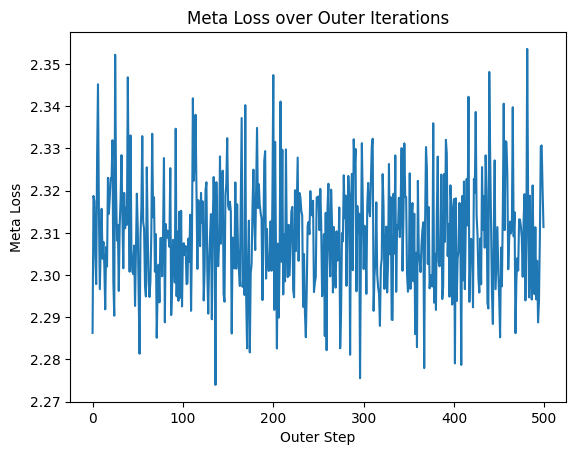

Training final model on distilled synthetic dataset...
Epoch [1/10], Training Loss on distilled data: 2.3012
Epoch [2/10], Training Loss on distilled data: 2.2113
Epoch [3/10], Training Loss on distilled data: 2.1301
Epoch [4/10], Training Loss on distilled data: 2.0382
Epoch [5/10], Training Loss on distilled data: 1.9423
Epoch [6/10], Training Loss on distilled data: 1.8110
Epoch [7/10], Training Loss on distilled data: 1.6602
Epoch [8/10], Training Loss on distilled data: 1.4768
Epoch [9/10], Training Loss on distilled data: 1.2710
Epoch [10/10], Training Loss on distilled data: 1.0636
Test accuracy of model trained on distilled data: 12.75%


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.func import functional_call

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#############################################
# Define a simple CNN (SimpleNet) for MNIST
#############################################
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 14 * 14)
        self.fc2 = nn.Linear(14 * 14, 7 * 7)
        self.fc3 = nn.Linear(7 * 7, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

#############################################
# Main function: Differentiable meta-model matching
#############################################
def main():
    # Hyperparameters
    num_classes = 10
    syn_size = 100          # total number of synthetic images (for simplicity, 50 images total)
    inner_steps = 50        # inner-loop update steps
    outer_steps = 500       # outer-loop iterations
    lr_syn = 0.01           # learning rate for synthetic data update
    lr_model = 0.01         # learning rate for inner-loop (model) update

    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    # We'll use one batch at a time for meta-loss computation
    real_iter = iter(train_loader)
    
    #############################################
    # Initialize synthetic dataset as learnable parameters
    #############################################
    # Synthetic images: shape [syn_size, 1, 28, 28]
    syn_images = torch.randn((syn_size, 1, 28, 28), requires_grad=True, device=device)
    # Synthetic labels: here we use randomly assigned labels (optionally these can be fixed or learnable)
    syn_labels = torch.randint(0, num_classes, (syn_size,), device=device)
    # Represent labels as one-hot vectors (and allow gradients if desired)
    syn_labels = nn.functional.one_hot(syn_labels, num_classes).float().requires_grad_(True)

    # Optimizer for synthetic data (images and labels)
    optimizer_syn = optim.SGD([syn_images, syn_labels], lr=lr_syn)

    # Loss tracking for meta-loss
    meta_losses = []

    print("Starting meta-training for dataset distillation...")
    for outer_step in range(outer_steps):
        # Reinitialize a fresh model for this meta-iteration
        model = SimpleNet().to(device)
        model.train()
        
        # Save a copy of the initial parameters (as a dict) in a differentiable way
        init_params = {name: param.clone() for name, param in model.named_parameters()}
        
        # Get one batch from real data for meta-loss computation
        try:
            real_images, real_labels = next(real_iter)
        except StopIteration:
            real_iter = iter(train_loader)
            real_images, real_labels = next(real_iter)
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        
        # --------------------------------------
        # Inner loop: differentiably train on synthetic data
        # --------------------------------------
        # Initialize parameter dictionary for inner-loop
        params = {name: param.clone() for name, param in init_params.items()}
        for step in range(inner_steps):
            # Forward pass on synthetic data using current parameters
            outputs_syn = functional_call(model, params, syn_images)
            loss_syn = F.cross_entropy(outputs_syn, syn_labels.argmax(dim=1))
            # Compute gradients with respect to current model parameters; create_graph=True for differentiability
            grads = torch.autograd.grad(loss_syn, params.values(), create_graph=True)
            # Update parameters functionally
            params = {name: params[name] - lr_model * grad 
                      for name, grad in zip(params.keys(), grads)}
        
        # --------------------------------------
        # Outer loop: compute meta-loss on real data using final inner-loop parameters
        # --------------------------------------
        outputs_real = functional_call(model, params, real_images)
        meta_loss = F.cross_entropy(outputs_real, real_labels)
        
        # Record meta loss for plotting
        meta_losses.append(meta_loss.item())
        
        # Backpropagate meta loss through inner loop to synthetic data
        optimizer_syn.zero_grad()
        meta_loss.backward()
        optimizer_syn.step()
        
        if outer_step % 10 == 0:
            print(f"Outer Step [{outer_step}/{outer_steps}], Meta Loss: {meta_loss.item():.4f}")
    
    print("Meta-training finished.")
    
    # Plot meta loss learning curve
    plt.plot(meta_losses)
    plt.xlabel("Outer Step")
    plt.ylabel("Meta Loss")
    plt.title("Meta Loss over Outer Iterations")
    plt.show()
    
    #############################################
    # Evaluation: Train a fresh model on the distilled synthetic dataset
    #############################################
    print("Training final model on distilled synthetic dataset...")
    # Create a dataset from synthetic images and labels (using argmax on one-hot)
    syn_dataset = TensorDataset(syn_images.detach().cpu(), syn_labels.argmax(dim=1).detach().cpu())
    syn_loader = DataLoader(syn_dataset, batch_size=32, shuffle=True)
    
    final_model = SimpleNet().to(device)
    final_model.train()
    optimizer_final = optim.SGD(final_model.parameters(), lr=0.1)
    num_epochs = 10
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for imgs, labels in syn_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = final_model(imgs)
            loss = F.cross_entropy(outputs, labels)
            optimizer_final.zero_grad()
            loss.backward()
            optimizer_final.step()
            epoch_loss += loss.item() * imgs.size(0)
        epoch_loss /= len(syn_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss on distilled data: {epoch_loss:.4f}")
    
    # Test final model on MNIST test set
    final_model.eval()
    correct = 0
    total = 0
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = final_model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100.0 * correct / total
    print(f"Test accuracy of model trained on distilled data: {test_acc:.2f}%")

if __name__ == '__main__':
    main()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.func import functional_call
import time
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import random

class Args:
    """Configuration settings"""
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 42
        self.epochs = 1000              # Outer-loop iterations
        self.inner_epochs = 10          # Inner-loop iterations (reduced for stability)
        self.lr_model = 0.01            # Inner-loop learning rate
        self.lr_synth = 0.005             # Learning rate for synthetic data
        self.ipc = 10                   # Images per class
        self.num_classes = 10
        self.batch_size = 256
        self.eval_batch_size = 1000
        self.real_batch_size = 256      # Size of real data batch for meta-loss
        self.img_size = 28
        self.channels = 1
        self.model_type = 'simple'      # 'simple' or 'cnn'
        self.save_dir = './distilled_data_improved'
        self.weight_decay = 5e-4        # Weight decay for inner loop
        # Multiple real batches for more stable meta-loss
        self.num_real_batches = 4
        # Use image normalization for better training
        self.mean = 0.1307
        self.std = 0.3081
        # Improved optimizer settings
        self.syn_optim = 'adam'         # 'sgd' or 'adam'
        self.momentum = 0.9             # SGD momentum
        # Initialization method
        self.init_type = 'real'         # 'random', 'real', or 'normal'
        # Temperature for softmax when computing meta-loss
        self.temperature = 1.0
        # Improved sampling strategy
        self.sample_strategy = 'stratified'  # 'random' or 'stratified'

def set_seed(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Network architectures
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def get_network(args):
    """Create and initialize the neural network"""
    if args.model_type == 'simple':
        return SimpleNet().to(args.device)
    elif args.model_type == 'cnn':
        return ConvNet().to(args.device)
    else:
        raise ValueError("Invalid model type")

def get_datasets(args):
    """Load MNIST datasets with appropriate transforms"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((args.mean,), (args.std,))
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Create stratified subset for each class
    if args.sample_strategy == 'stratified':
        # Create class-balanced training subset
        train_indices = []
        for c in range(args.num_classes):
            idx = (train_dataset.targets == c).nonzero().flatten().tolist()
            train_indices.extend(idx[:5000])  # Limit per class for balanced training
        
        train_subset = Subset(train_dataset, train_indices)
        train_loader = DataLoader(train_subset, batch_size=args.batch_size, shuffle=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    
    test_loader = DataLoader(test_dataset, batch_size=args.eval_batch_size, shuffle=False)
    
    return train_dataset, train_loader, test_loader

def initialize_synthetic_data(args, train_dataset):
    """Initialize synthetic data with improved strategies"""
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    
    # Initialize synthetic images with different strategies
    if args.init_type == 'random':
        # Random initialization
        syn_images = torch.randn(
            (args.num_classes * args.ipc, args.channels, args.img_size, args.img_size),
            device=args.device
        )
    elif args.init_type == 'real':
        # Initialize with real images
        indices_class = [[] for _ in range(args.num_classes)]
        for i, label in enumerate(train_dataset.targets):
            indices_class[label].append(i)
        
        syn_images = []
        for c in range(args.num_classes):
            # Randomly select IPC images for class c
            idx_shuffle = np.random.permutation(indices_class[c])[:args.ipc]
            for i in idx_shuffle:
                syn_images.append(train_dataset[i][0])
        
        syn_images = torch.stack(syn_images).to(args.device)
    else:  # 'normal'
        # Gaussian initialization with controlled mean and std
        syn_images = torch.randn(
            (args.num_classes * args.ipc, args.channels, args.img_size, args.img_size),
            device=args.device
        ) * 0.1 + 0.5
    
    # Create balanced labels
    syn_labels = torch.tensor([i for i in range(args.num_classes) for _ in range(args.ipc)], 
                            device=args.device)
    
    # Make synthetic images trainable
    syn_images.requires_grad_(True)
    
    return syn_images, syn_labels

def train_on_synthetic(model, params, images, labels, args):
    """Inner loop: train model on synthetic data with improved training dynamics"""
    for i in range(args.inner_epochs):
        # Forward pass on synthetic data
        outputs = functional_call(model, params, images)
        loss = F.cross_entropy(outputs, labels)
        
        # Add L2 regularization
        l2_reg = 0.0
        for param in params.values():
            l2_reg += torch.norm(param) ** 2
        loss = loss + args.weight_decay * l2_reg
        
        # Compute gradients with respect to current model parameters
        grads = torch.autograd.grad(loss, params.values(), create_graph=True)
        
        # Adjust learning rate with decay schedule
        lr_decay = 1.0  # You can implement cosine decay here if needed
        current_lr = args.lr_model * lr_decay
        
        # Update parameters functionally
        params = {
            name: param - current_lr * g
            for (name, param), g in zip(params.items(), grads)
        }
    
    return params

def evaluate_model(model, data_loader, device):
    """Evaluate model accuracy on the given data loader"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def dataset_distillation(args):
    """Main function for dataset distillation with improved techniques"""
    print(f"Using device: {args.device}")
    set_seed(args.seed)
    
    # Load datasets
    train_dataset, train_loader, test_loader = get_datasets(args)
    
    # Initialize synthetic data
    syn_images, syn_labels = initialize_synthetic_data(args, train_dataset)
    
    # Initialize optimizer for synthetic data
    if args.syn_optim == 'sgd':
        optimizer_syn = optim.SGD([syn_images], lr=args.lr_synth, momentum=args.momentum)
        scheduler_syn = StepLR(optimizer_syn, step_size=args.epochs//3, gamma=0.5)
    else:  # adam
        optimizer_syn = optim.Adam([syn_images], lr=args.lr_synth, betas=(0.9, 0.999))
        scheduler_syn = CosineAnnealingLR(optimizer_syn, T_max=args.epochs, eta_min=args.lr_synth/100)
    
    # For recording metrics
    meta_losses = []
    test_accuracies = []
    start_time = time.time()
    
    print(f"Starting meta-training with {args.ipc} images per class...")
    best_meta_loss = float('inf')
    
    # Create multiple real batch iterators
    real_iterators = [iter(train_loader) for _ in range(args.num_real_batches)]
    
    # Training loop
    for epoch in range(args.epochs):
        # Track batch meta-losses
        batch_meta_losses = []
        
        # Iterate through multiple real batches for stable meta-gradient
        for batch_idx in range(args.num_real_batches):
            # Get a batch of real data
            try:
                real_images, real_labels = next(real_iterators[batch_idx])
            except StopIteration:
                real_iterators[batch_idx] = iter(train_loader)
                real_images, real_labels = next(real_iterators[batch_idx])
            
            real_images, real_labels = real_images.to(args.device), real_labels.to(args.device)
            
            # Initialize a fresh model
            model = get_network(args)
            model.train()
            
            # Get initial parameters
            init_params = {name: param.clone() for name, param in model.named_parameters()}
            
            # Inner loop: train on synthetic data
            final_params = train_on_synthetic(model, init_params, syn_images, syn_labels, args)
            
            # Outer loop: compute meta-loss on real data
            outputs_real = functional_call(model, final_params, real_images)
            
            # Compute meta-loss with temperature scaling for soft targets (optional)
            if args.temperature != 1.0:
                outputs_real = outputs_real / args.temperature
            
            meta_loss = F.cross_entropy(outputs_real, real_labels)
            batch_meta_losses.append(meta_loss)
        
        # Average meta-loss over all real batches
        meta_loss = torch.mean(torch.stack(batch_meta_losses))
        
        # Update synthetic data
        optimizer_syn.zero_grad()
        meta_loss.backward()
        
        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_([syn_images], 10.0)
        
        optimizer_syn.step()
        scheduler_syn.step()
        
        # Clip synthetic images to valid range (optional but helpful)
        with torch.no_grad():
            syn_images.data = torch.clamp(syn_images.data, -2.0, 2.0)
        
        # Record metrics
        meta_losses.append(meta_loss.item())
        
        # Periodic evaluation and logging
        if (epoch + 1) % 50 == 0 or epoch == 0:
            # Evaluate a model trained on the current synthetic dataset
            eval_model = get_network(args)
            eval_optimizer = optim.SGD(eval_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
            eval_scheduler = CosineAnnealingLR(eval_optimizer, T_max=200, eta_min=0.0001)
            
            # Train on synthetic data
            for e in range(200):  # More epochs for evaluation
                eval_model.train()
                outputs = eval_model(syn_images)
                loss = F.cross_entropy(outputs, syn_labels)
                eval_optimizer.zero_grad()
                loss.backward()
                eval_optimizer.step()
                eval_scheduler.step()
            
            # Test accuracy
            test_acc = evaluate_model(eval_model, test_loader, args.device)
            test_accuracies.append(test_acc)
            
            # Save synthetic data if improved
            if meta_loss.item() < best_meta_loss:
                best_meta_loss = meta_loss.item()
                torch.save({
                    'syn_images': syn_images.detach().cpu(),
                    'syn_labels': syn_labels.detach().cpu(),
                    'meta_loss': best_meta_loss,
                    'test_acc': test_acc
                }, f"{args.save_dir}/best_synth_data.pt")
                # Also save a checkpoint every time we improve
                torch.save({
                    'epoch': epoch,
                    'syn_images': syn_images.detach().cpu(),
                    'syn_labels': syn_labels.detach().cpu(),
                    'optimizer': optimizer_syn.state_dict(),
                    'scheduler': scheduler_syn.state_dict(),
                    'meta_losses': meta_losses,
                    'test_accuracies': test_accuracies
                }, f"{args.save_dir}/checkpoint.pt")
            
            # Always save latest synthetic data
            torch.save({
                'syn_images': syn_images.detach().cpu(),
                'syn_labels': syn_labels.detach().cpu()
            }, f"{args.save_dir}/latest_synth_data.pt")
            
            # Calculate elapsed time and estimated time remaining
            elapsed = time.time() - start_time
            estimated_total = elapsed / (epoch + 1) * args.epochs
            remaining = estimated_total - elapsed
            
            print(f"Epoch [{epoch+1}/{args.epochs}], Meta Loss: {meta_loss.item():.4f}, "
                  f"Test Acc: {test_acc:.2f}%, "
                  f"Time: {elapsed:.1f}s, ETA: {remaining/60:.1f}min")
        
        # Save learning curves periodically
        if (epoch + 1) % 100 == 0:
            plot_learning_curves(meta_losses, test_accuracies, args)
    
    # Final evaluation
    print("\nMeta-training completed. Training final model on distilled dataset...")
    
    # Load best synthetic data
    checkpoint = torch.load(f"{args.save_dir}/best_synth_data.pt")
    best_syn_images = checkpoint['syn_images'].to(args.device)
    best_syn_labels = checkpoint['syn_labels'].to(args.device)
    best_meta_loss = checkpoint['meta_loss']
    
    print(f"Best meta loss achieved: {best_meta_loss:.4f}")
    
    # Train a final model with the distilled dataset
    final_model = get_network(args)
    final_optimizer = optim.SGD(final_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    final_scheduler = CosineAnnealingLR(final_optimizer, T_max=500, eta_min=0.0001)
    
    for epoch in range(500):  # More epochs for final evaluation
        final_model.train()
        outputs = final_model(best_syn_images)
        loss = F.cross_entropy(outputs, best_syn_labels)
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()
        final_scheduler.step()
        
        if (epoch + 1) % 100 == 0:
            train_acc = evaluate_model(final_model, train_loader, args.device)
            test_acc = evaluate_model(final_model, test_loader, args.device)
            print(f"Final Model - Epoch [{epoch+1}/500], Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")
    
    # Save final model
    torch.save(final_model.state_dict(), f"{args.save_dir}/final_model.pt")
    
    # Visualize distilled images
    save_distilled_images(best_syn_images, best_syn_labels, args)
    
    # Plot final learning curves
    plot_learning_curves(meta_losses, test_accuracies, args)
    
    return best_syn_images, best_syn_labels, final_model

def save_distilled_images(images, labels, args):
    """Save distilled images as a grid"""
    import torchvision.utils as vutils
    
    # Denormalize images
    denorm = transforms.Normalize((-args.mean/args.std,), (1/args.std,))
    images_denorm = torch.stack([denorm(img) for img in images])
    
    # Create a figure with subplots for each class
    plt.figure(figsize=(12, 10))
    
    # Organize images by class
    images_by_class = [[] for _ in range(args.num_classes)]
    for i, label in enumerate(labels):
        images_by_class[label].append(images_denorm[i])
    
    for c in range(args.num_classes):
        if images_by_class[c]:
            class_images = torch.stack(images_by_class[c])
            # Create grid for this class
            grid = vutils.make_grid(class_images, nrow=min(5, len(class_images)), 
                                   padding=2, normalize=True)
            
            # Plot in subplot
            plt.subplot(4, 3, c+1)
            plt.title(f"Class {c}")
            plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{args.save_dir}/distilled_images_by_class.png", dpi=300)
    plt.close()
    
    # Also create a single grid with all images
    grid = vutils.make_grid(images_denorm, nrow=args.ipc, padding=2, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.title(f"All Distilled MNIST Images ({args.ipc} per class)")
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{args.save_dir}/distilled_images_all.png", dpi=300)
    plt.close()

def plot_learning_curves(meta_losses, test_accuracies, args):
    """Plot meta-loss and test accuracy curves"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(meta_losses)
    plt.title('Meta-Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Meta-Loss')
    plt.grid(True)
    
    # Add a smoothed line
    if len(meta_losses) > 10:
        from scipy.ndimage import gaussian_filter1d
        y_smooth = gaussian_filter1d(meta_losses, sigma=5)
        plt.plot(y_smooth, 'r-')
    
    plt.subplot(1, 2, 2)
    epochs_eval = [i*50 for i in range(len(test_accuracies))]
    plt.plot(epochs_eval, test_accuracies, 'o-')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{args.save_dir}/learning_curves.png", dpi=300)
    plt.close()

def run():
    """Main entry point with argument parsing"""
    args = Args()
    
    # Display configuration
    print("Dataset Distillation Configuration:")
    print(f"- Device: {args.device}")
    print(f"- Images per class: {args.ipc}")
    print(f"- Outer epochs: {args.epochs}")
    print(f"- Inner epochs: {args.inner_epochs}")
    print(f"- Model type: {args.model_type}")
    print(f"- Optimizer: {args.syn_optim}")
    print(f"- Initialization: {args.init_type}")
    print(f"- Batch size: {args.batch_size}")
    print(f"- Real batches per meta-update: {args.num_real_batches}")
    print(f"- Save directory: {args.save_dir}")
    
    # Run dataset distillation
    dataset_distillation(args)

if __name__ == "__main__":
    run()

Dataset Distillation Configuration:
- Device: cpu
- Images per class: 10
- Outer epochs: 1000
- Inner epochs: 10
- Model type: simple
- Optimizer: adam
- Initialization: real
- Batch size: 256
- Real batches per meta-update: 4
- Save directory: ./distilled_data_improved
Using device: cpu
Starting meta-training with 10 images per class...
Epoch [1/1000], Meta Loss: 2.3042, Test Acc: 74.63%, Time: 0.9s, ETA: 15.3min
Epoch [50/1000], Meta Loss: 2.3048, Test Acc: 78.16%, Time: 12.9s, ETA: 4.1min
Epoch [100/1000], Meta Loss: 2.3054, Test Acc: 78.79%, Time: 23.4s, ETA: 3.5min
Epoch [150/1000], Meta Loss: 2.3011, Test Acc: 77.17%, Time: 34.0s, ETA: 3.2min
Epoch [200/1000], Meta Loss: 2.3072, Test Acc: 77.24%, Time: 44.3s, ETA: 3.0min
Epoch [250/1000], Meta Loss: 2.3046, Test Acc: 76.30%, Time: 55.7s, ETA: 2.8min
Epoch [300/1000], Meta Loss: 2.2938, Test Acc: 75.25%, Time: 67.1s, ETA: 2.6min
Epoch [350/1000], Meta Loss: 2.3020, Test Acc: 79.20%, Time: 80.3s, ETA: 2.5min
Epoch [400/1000], Meta 

Starting meta-optimization...
Iter   0: Meta-loss: 2.3006, TV: 170498.5156, Total Meta: 19.3504, Avg Inner-loss: 0.0818, Grad Norms: Images 0.0770, Labels 0.0021
Iter  10: Meta-loss: 2.3013, TV: 168670.1875, Total Meta: 19.1684, Avg Inner-loss: 0.0850, Grad Norms: Images 0.0768, Labels 0.0025
Iter  20: Meta-loss: 2.3022, TV: 166855.4688, Total Meta: 18.9877, Avg Inner-loss: 0.0855, Grad Norms: Images 0.0765, Labels 0.0050
Iter  30: Meta-loss: 2.3068, TV: 165053.7188, Total Meta: 18.8122, Avg Inner-loss: 0.0599, Grad Norms: Images 0.0763, Labels 0.0028
Iter  40: Meta-loss: 2.2984, TV: 163265.0312, Total Meta: 18.6249, Avg Inner-loss: 0.0698, Grad Norms: Images 0.0763, Labels 0.0053
Iter  50: Meta-loss: 2.2994, TV: 161490.3125, Total Meta: 18.4484, Avg Inner-loss: 0.0612, Grad Norms: Images 0.0758, Labels 0.0041
Iter  60: Meta-loss: 2.2787, TV: 159729.9062, Total Meta: 18.2517, Avg Inner-loss: 0.0653, Grad Norms: Images 0.0759, Labels 0.0083
Iter  70: Meta-loss: 2.3019, TV: 157983.5625, 

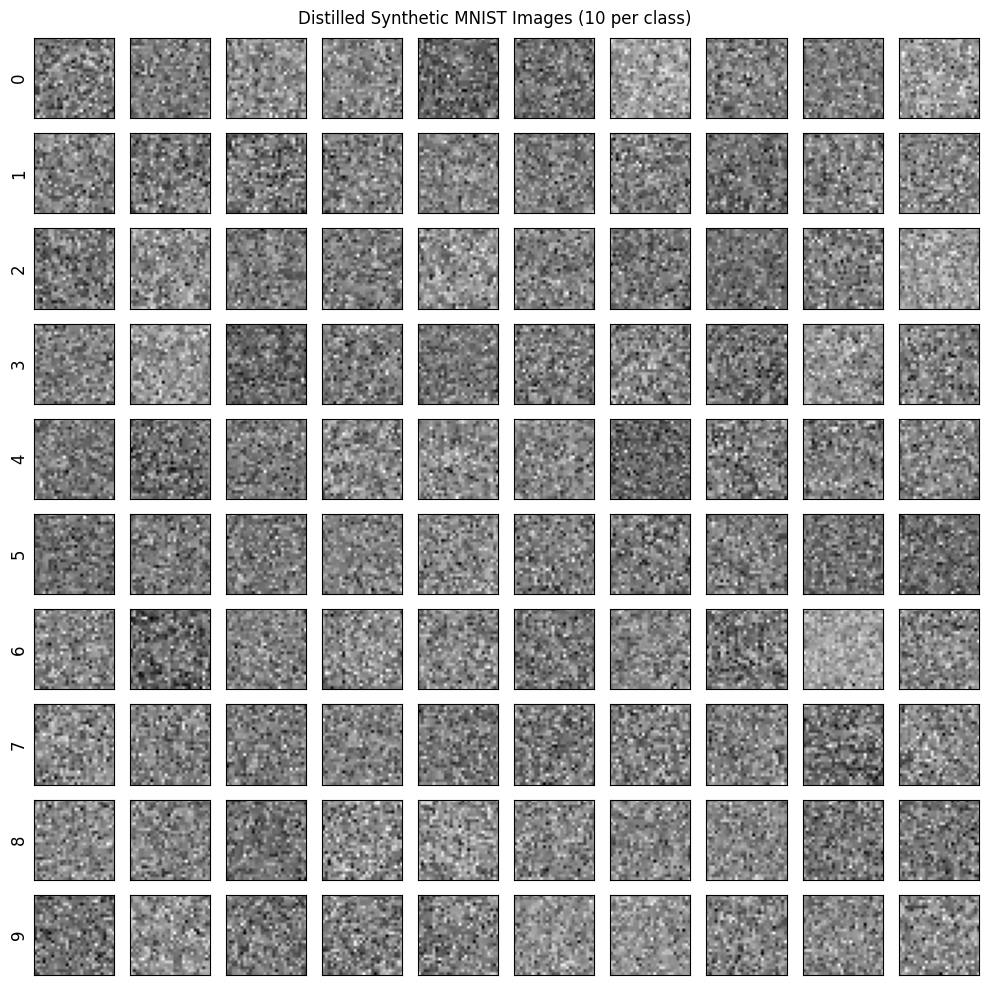

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.func import functional_call
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device: GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Define a simple CNN model
# ---------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # 16x28x28
        self.pool = nn.MaxPool2d(2, 2)                              # 16x14x14
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)    # 32x14x14
        self.fc1 = nn.Linear(32 * 14 * 14, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# ---------------------------
# Load MNIST real dataset
# ---------------------------
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)

# ---------------------------
# Initialize Synthetic Dataset
# ---------------------------
num_syn = 100  # 10 images per each of 10 classes

# Option 1: Initialize synthetic images as random noise (default)
syn_images = torch.randn(num_syn, 1, 28, 28, device=device, requires_grad=True)

# Option 2 (alternative): Initialize from real data (uncomment to use)
# real_data_iter = iter(train_loader)
# real_images, real_labels = next(real_data_iter)
# # Select 10 examples per class (this is a crude selection)
# syn_list = []
# for c in range(10):
#     idx = (real_labels == c).nonzero(as_tuple=True)[0][:10]
#     syn_list.append(real_images[idx])
# syn_images = torch.cat(syn_list, dim=0).clone().detach().to(device)
# syn_images.requires_grad_()

# Initialize synthetic labels: first create without grad, then enable gradients.
syn_labels = torch.zeros(num_syn, 10, device=device)
for i in range(10):
    syn_labels[i*10:(i+1)*10, i] = 1.0
syn_labels.requires_grad_()

# ---------------------------
# Outer optimizer for synthetic data parameters using Adam
# ---------------------------
outer_optimizer = optim.Adam([syn_images, syn_labels], lr=0.001)

# ---------------------------
# Total Variation Loss (Regularizer)
# ---------------------------
def total_variation_loss(x):
    tv_h = torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    tv_w = torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]))
    return tv_h + tv_w

tv_weight = 1e-4  # Weight for total variation regularization

# ---------------------------
# Hyperparameters
# ---------------------------
K = 1000   # number of outer iterations
T = 25     # number of inner-loop updates
eta = 0.1  # inner-loop learning rate

# ---------------------------
# Training (Meta-Optimization)
# ---------------------------
print("Starting meta-optimization...")
for outer_iter in range(K):
    # Instantiate the network and get its initial parameters as a dictionary.
    net = SimpleCNN(num_classes=10).to(device)
    theta = {name: param.detach().clone().requires_grad_() for name, param in net.named_parameters()}

    inner_loss_sum = 0.0  # To monitor inner-loop loss
    # --------
    # Inner-loop: update network parameters by training on the synthetic data
    # --------
    for t in range(T):
        # Forward pass using functional_call with current theta
        outputs_syn = functional_call(net, theta, syn_images)
        # Compute the inner loss: KL divergence between log-softmax of outputs and softmax of synthetic labels
        loss_syn = F.kl_div(F.log_softmax(outputs_syn, dim=1), 
                            F.softmax(syn_labels, dim=1), 
                            reduction='batchmean')
        inner_loss_sum += loss_syn.item()

        # Compute gradients w.r.t. theta with create_graph=True
        grads = torch.autograd.grad(loss_syn, theta.values(), create_graph=True)
        # Update theta: differentiable gradient descent step
        theta = {name: theta[name] - eta * grad for name, grad in zip(theta.keys(), grads)}

    avg_inner_loss = inner_loss_sum / T

    # --------
    # Outer-loop (Meta-loss): Sample a batch from the real MNIST data and compute the loss.
    # --------
    try:
        real_images, real_labels = next(real_iter)
    except:
        real_iter = iter(train_loader)
        real_images, real_labels = next(real_iter)
    real_images, real_labels = real_images.to(device), real_labels.to(device)
    outputs_real = functional_call(net, theta, real_images)
    meta_loss = F.cross_entropy(outputs_real, real_labels)
    
    # Add TV regularization on synthetic images
    tv_loss = total_variation_loss(syn_images)
    meta_loss_total = meta_loss + tv_weight * tv_loss

    # --------
    # Backpropagation: update synthetic images and labels using the meta-loss
    # --------
    outer_optimizer.zero_grad()
    meta_loss_total.backward()
    outer_optimizer.step()

    # Monitor gradient norms for synthetic images and labels
    syn_images_grad_norm = syn_images.grad.norm().item() if syn_images.grad is not None else 0.0
    syn_labels_grad_norm = syn_labels.grad.norm().item() if syn_labels.grad is not None else 0.0

    if outer_iter % 10 == 0:
        print(f"Iter {outer_iter:3d}: Meta-loss: {meta_loss.item():.4f}, TV: {tv_loss.item():.4f}, "
              f"Total Meta: {meta_loss_total.item():.4f}, Avg Inner-loss: {avg_inner_loss:.4f}, "
              f"Grad Norms: Images {syn_images_grad_norm:.4f}, Labels {syn_labels_grad_norm:.4f}")

# ---------------------------
# Visualize the distilled synthetic images
# ---------------------------
def imshow(img_tensor, title=""):
    img_np = img_tensor.detach().cpu().numpy().squeeze()
    plt.imshow(img_np, cmap='gray')
    plt.title(title)
    plt.axis('off')

# Create a grid: 10 images per class
syn_images_np = syn_images.detach().cpu().clone()
syn_labels_np = F.softmax(syn_labels, dim=1).detach().cpu().numpy()
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for cls in range(10):
    idx = np.where(syn_labels_np.argmax(axis=1) == cls)[0]
    idx = idx[:10]  # take first 10 if there are more
    for j, i in enumerate(idx):
        axes[cls, j].imshow(syn_images_np[i].squeeze(), cmap='gray')
        axes[cls, j].set_xticks([])
        axes[cls, j].set_yticks([])
        if j == 0:
            axes[cls, j].set_ylabel(str(cls), fontsize=12)
plt.suptitle("Distilled Synthetic MNIST Images (10 per class)")
plt.tight_layout()
plt.show()
